### Data Loading and EDA

In [1]:
import pandas as pd
import os
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if ';' in line:
                tweet, label = line.strip().split(';')
                data.append({'text': tweet, 'emotion': label})
    return pd.DataFrame(data)

# Load datasets
train_data = load_data('train.txt')
test_data = load_data('test.txt')

# Display the first few rows of the datasets
print(train_data.head())
print(test_data.head())



                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
                                                text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness


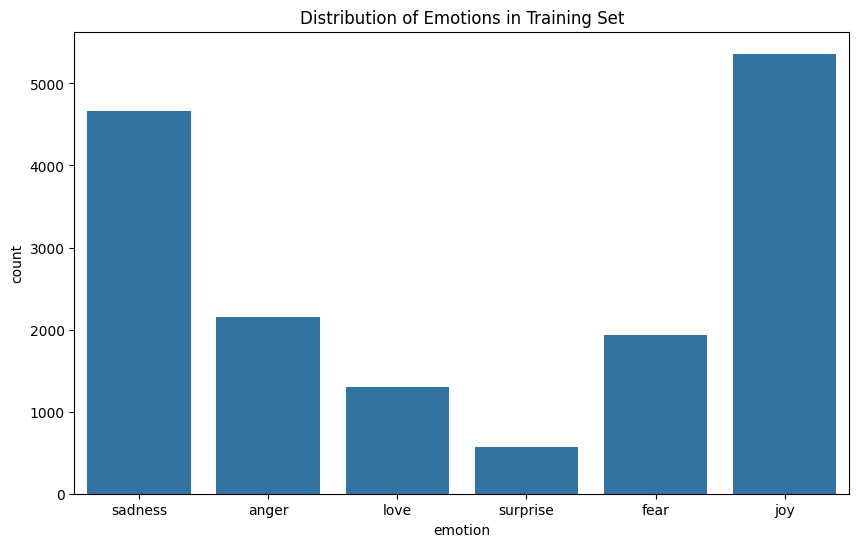

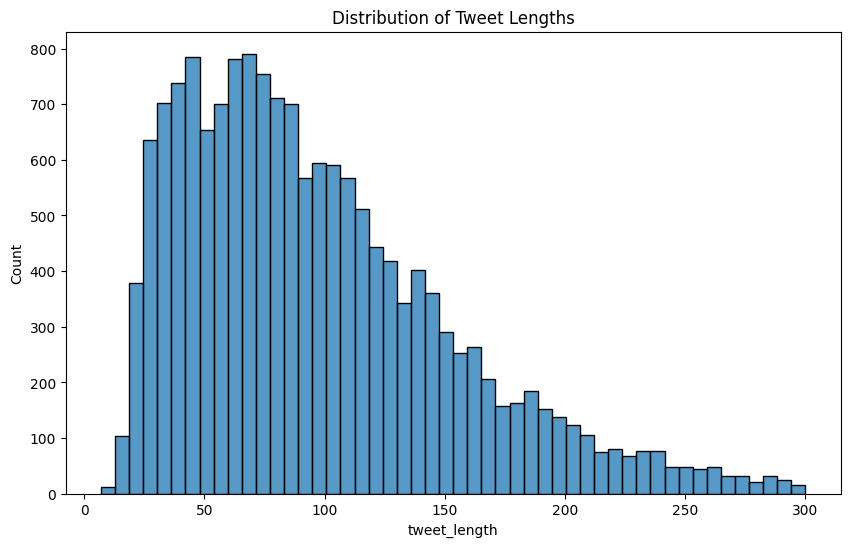

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of emotions
plt.figure(figsize=(10,6))
sns.countplot(x='emotion', data=train_data)
plt.title('Distribution of Emotions in Training Set')
plt.show()

# Display tweet lengths
train_data['tweet_length'] = train_data['text'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(train_data['tweet_length'], bins=50)
plt.title('Distribution of Tweet Lengths')
plt.show()


### Data Preprocessing

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

train_data['clean_text'] = train_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

print(train_data[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...


                                                text  \
0                            i didnt feel humiliated   
1  i can go from feeling so hopeless to so damned...   
2   im grabbing a minute to post i feel greedy wrong   
3  i am ever feeling nostalgic about the fireplac...   
4                               i am feeling grouchy   

                                          clean_text  
0                              didnt feel humiliated  
1  go feeling hopeless damned hopeful around some...  
2          im grabbing minute post feel greedy wrong  
3  ever feeling nostalgic fireplace know still pr...  
4                                    feeling grouchy  


In [8]:
# Verify that lengths of columns are the same
print(len(train_data['clean_text']), len(train_data['emotion']))
print(len(test_data['clean_text']), len(test_data['emotion']))

16000 16000
2000 2000


### FCNN

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['clean_text']).toarray()
X_test = vectorizer.transform(test_data['clean_text']).toarray()

# Label Encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_data['emotion'])
y_test = encoder.transform(test_data['emotion'])

# Split the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build FCNN Model
model = Sequential()
model.add(Dense(512, input_dim=5000, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(encoder.classes_), activation='softmax'))

# Compile and Train the Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


c:\Users\sanja\anaconda3\envs\my-env\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5006 - loss: 1.2816 - val_accuracy: 0.8528 - val_loss: 0.4367
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9427 - loss: 0.1819 - val_accuracy: 0.8603 - val_loss: 0.4000
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9856 - loss: 0.0458 - val_accuracy: 0.8641 - val_loss: 0.4357
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9943 - loss: 0.0200 - val_accuracy: 0.8575 - val_loss: 0.5092
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9951 - loss: 0.0159 - val_accuracy: 0.8475 - val_loss: 0.6125
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9972 - loss: 0.0095 - val_accuracy: 0.8659 - val_loss: 0.5615
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9953 - loss: 0.0127 - val_accuracy: 0.8572 - val_loss: 0.6106
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9971 - loss: 0.0072 - val_accu

### RNN (LSTM based)


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(train_data['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['clean_text'])

# Padding sequences
max_seq_length = 100
X_train_seq = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Label Encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_data['emotion'])
y_test = encoder.transform(test_data['emotion'])

# Ensure the sequence lengths match
assert len(X_train_seq) == len(y_train)
assert len(X_test_seq) == len(y_test)

# Split the data for validation
X_train_seq, X_val_seq, y_train, y_val = train_test_split(X_train_seq, y_train, test_size=0.2, random_state=42)

# Verify the shapes
print(X_train_seq.shape, y_train.shape)
print(X_val_seq.shape, y_val.shape)
print(X_test_seq.shape, y_test.shape)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input

model = Sequential()
model.add(Input(shape=(max_seq_length,)))
model.add(Embedding(input_dim=5000, output_dim=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_seq, y_train, epochs=10, batch_size=64, validation_data=(X_val_seq, y_val))

loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f'Test Accuracy: {accuracy}')


(12800, 100) (12800,)
(3200, 100) (3200,)
(2000, 100) (2000,)
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3788 - loss: 1.5390 - val_accuracy: 0.7656 - val_loss: 0.7551
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8402 - loss: 0.5061 - val_accuracy: 0.8934 - val_loss: 0.3042
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9419 - loss: 0.1710 - val_accuracy: 0.9134 - val_loss: 0.2427
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - accuracy: 0.9647 - loss: 0.0996 - val_accuracy: 0.9128 - val_loss: 0.2435
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9780 - loss: 0.0707 - val_accuracy: 0.9072 - val_loss: 0.3283
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9811 - loss: 0.0562 - val_accuracy: 0.9134 - val_loss: 0.2844
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.9852 - loss: 0.0458 - val_accuracy: 0.9084 - val_loss: 0.2967
Epoch 8/10
200/200 ━━━━━━━━━